# Fitting Tyre Deg Curves & Estimating Fuel Effect

This notebook summarises a simple example of how we can use historical F1 Grand Prix data to fit tyre deg (as well as fuel) effect on lap time.

All the historical race timing data has been sourced from the (publically available) Ergast API, available at http://ergast.com/mrd/. Please refer to the *README* file in the *download* folder of the Git repository for the relevant code that gets this data from the Ergast API, and stores it in BigQuery. The rest of this notebook assumes that these datasets have already been created within BigQuery, using the naming convention mentioned in that *README* document.

In [1]:
import Modelling_Utilities as mu
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Choose a Grand Prix & visually inspect the race lap times

In this example, we will use the 2019 Bahrain Grand Prix, which runs at a circuit that generally sees high tyre deg. We often see drivers looking after their tyres carefully in Bahrain, with multiple pit stops being needed to run the optimal race.

In [2]:
year = 2019
round_num = 2

In [3]:
results_df = mu.download_laptimes(year, round_num)
print(results_df.columns)

Index(['year', 'round', 'raceName', 'circuitName', 'driver_name',
       'constructor_name', 'best_qual_time', 'best_qual_time_adjusted',
       'best_qual_time_adjusted_flag', 'lap_number', 'perc_race_completed',
       'race_position', 'lap_time', 'pitstop_number_inlap',
       'pitstop_number_outlap', 'circuit_tyre_stress_rating',
       'circuit_asphalt_abrasion_rating', 'circuit_asphalt_grip_rating',
       'circuit_downforce_rating', 'circuit_lateral_rating',
       'tyre_stint_number', 'tyre', 'tyre_description', 'tyre_status',
       'tyre_age_laps', 'upload_timestamp'],
      dtype='object')


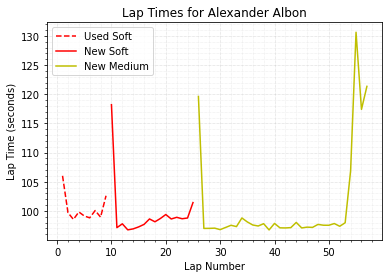

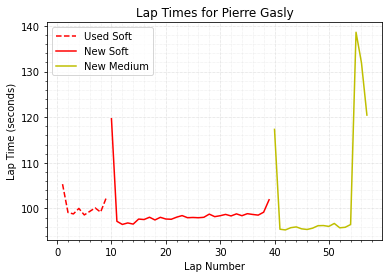

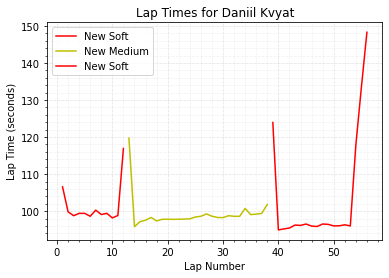

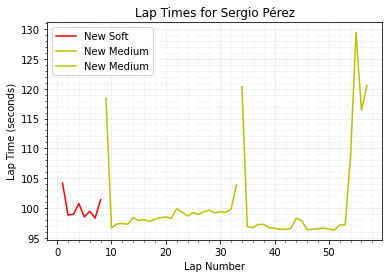

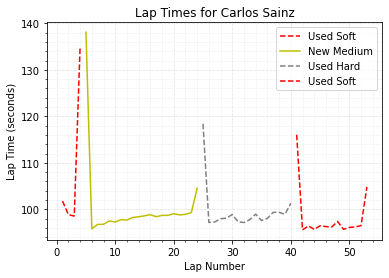

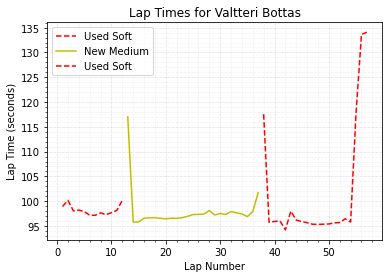

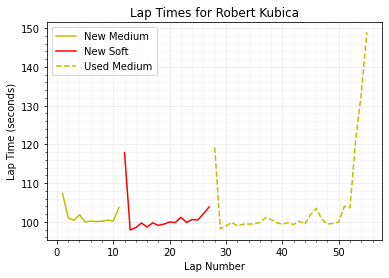

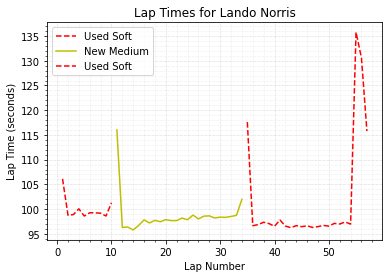

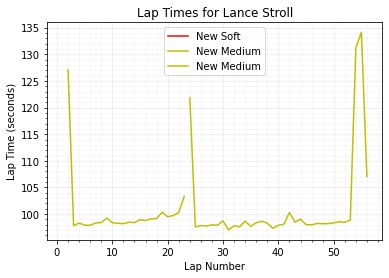

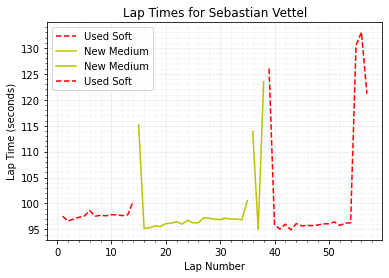

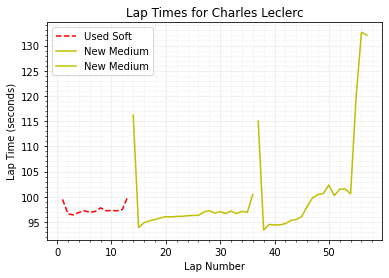

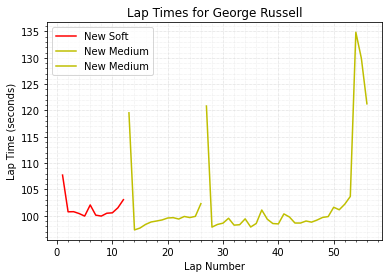

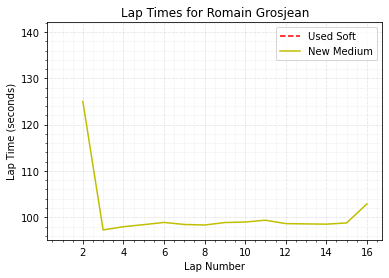

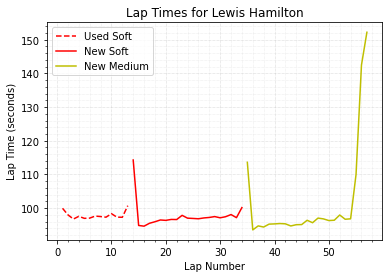

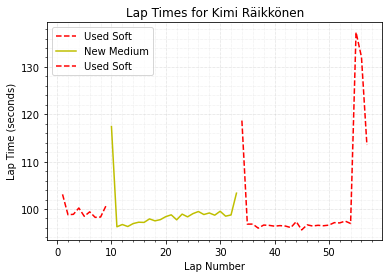

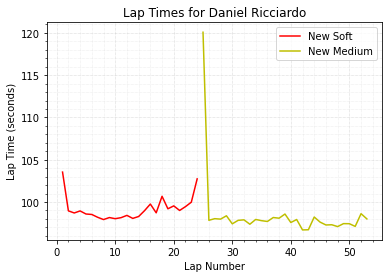

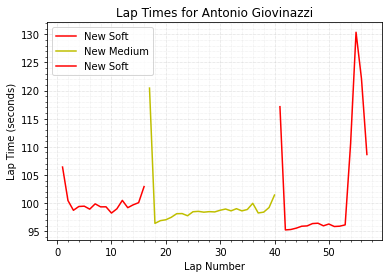

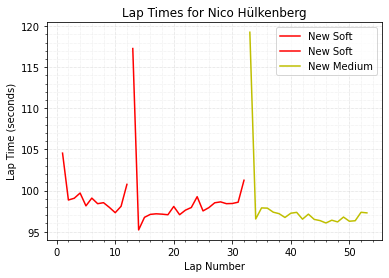

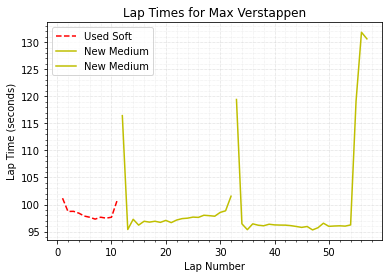

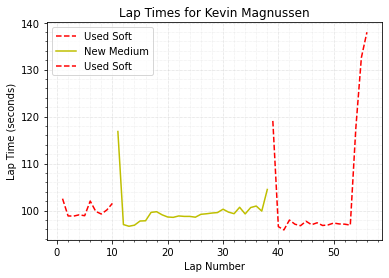

In [4]:
drivers_unique = list(dict.fromkeys(list(results_df['driver_name']))) # Removes duplicates
for d in drivers_unique:
    driver_df = results_df[results_df['driver_name'] == d]
    mu.plot_laptimes(driver_df, title = "Lap Times for {0}".format(d))

## 2. Formulate an intuitive idea for a model

For our first model we will assume the following relationship between lap time and other variables, for each driver:

$$l = \sum_{i=1}^{i=3} (\alpha_i t_i^2 + \beta_i t_i + \gamma_i)1_{i} + \delta n + \epsilon q + \zeta_{in} p_{in} + \zeta_{out} p_{out},$$

where:
- $l$ is the vector of lap times for the full race
- $t_i$ are the vectors of the age of each type of tyre on each lap; here the subscript $i = 1, 2, 3$ represents soft, medium and hard tyres respectively, and the entries are zero where the respective tyre isn't being used on that lap
- $1_{i}$ are the indicator vectors of having soft, medium and hard tyres on, for $i = 1, 2, 3$ respectively (that is, their entries are 1 if the lap was done using that tyre, and 0 otherwise)
- $n$ is the vector consisting of number of laps to go, with the last lap set at zero
- $q$ is the best qualifying time of the driver, repeated across all entries of the vector
- $p_{in}$ is the vector and 1s and 0s, with a 1 where (and only where) that lap ended with a pitstop
- $p_{out}$ is the vector and 1s and 0s, with a 1 where (and only where) that lap started with a pitstop
- $\alpha_i$, $\beta_i$, $\gamma_i$, $\delta$, $\epsilon$, $\zeta_{in}$ and $\zeta_{out}$ are all parameters to be chosen by the model to mimimise the RMSE (root mean square error)

To give some intuition as to why we are using this model:
- We assume that lap times drop off quadratically from tyre deg, and that the different tyre types vary in their tyre deg characteristics
- The parameter $\delta$ will capture the effect of using up fuel on lap time, which should turn out to be postive. We assume here that there is a linear relationship, i.e. that there is a constant lap time gain per lap, assuming the driver was to use the same amount of fuel on each lap.
- The parameter $\epsilon$ will relate the raw peak race performance against the best qualifying time of that driver as a percentage, to account for variances in vehicle and driver performance
- The parameters $\zeta_{in}$ and $\zeta_{out}$ will represent in the additional lap time required for an in-lap to the pits and out-lap from the pits, respectively

It should be noted here that all the greek letter parameters will vary, certainly from circuit to circuit, but also between teams and drivers. As we only have race data available here (no practice times), we have limited data to train on and so for simplicity we will assume that the parameters are the same for every driver, to get us a basic model for now.

## 3. Clean and prepare the data for modelling

As per the proposed model above, we will define the features that will go into the model.

Firstly, from visual inspection of the charts in section 1 above, there are some clear outliers that we should remove from our data, as those laps were affected by factors outside of our model:
- Laps 53 onwards were affected by a safety car period
- Laps 38 and 39 for Sebastian Vettel were affected by driver error (he span the car, hit the wall and lost his front wing, requiring a further unscheduled pit stop)
- Laps 46 onwards for Charles Leclerc were affected by mechanical issues (failure of an engine component, leading to a highly significant drop in performance)
- On lap 16, Romain Grosjean slowed to retire the car
- Lap 1 is the start of the race and so is affected by starting from the grid, first lap incidents etc

In [5]:
tyre_ages = results_df['tyre_age_laps'].to_numpy()
tyre_descriptions = results_df['tyre_description'].to_numpy()
lap_numbers = results_df['lap_number'].to_numpy()
drivers = results_df['driver_name'].to_numpy()
pitstops_in = np.nan_to_num(results_df['pitstop_number_inlap'].to_numpy())
pitstops_out = np.nan_to_num(results_df['pitstop_number_outlap'].to_numpy())
qualifying_times = results_df['best_qual_time_adjusted'].to_numpy()

Note here that the qualifying lap times are labelled as 'adjusted' - that is because in some rounds a driver may set no qualifying lap time. In this case, their qualifying time has been extrapolated using the median percentage difference between the best qualifying time in each 2019 race and that driver's best qualifying time. The 'best_qual_time_adjusted_flag' field in the dataset is 1 if this adjustment has been made, and 0 otherwise.\
Of course, in reality particularly in the early races of the year we wouldn't have this information. We would need to make an educated assumption on it, or alternatively remove that driver from the model. For this particular example of the Bahrain GP, there were no such instances and so the best qualifying lap times are in fact exact:

In [6]:
bqtaf = results_df['best_qual_time_adjusted_flag'].to_numpy()
len(bqtaf[bqtaf == 1])

0

We're now going to define a 'mask' *msk* of boolean values which will allow us to remove the outliers as identified earlier from our dataset.

In [7]:
cond1 = (lap_numbers >= 53)
cond2 = (lap_numbers >= 38) & (lap_numbers <= 39) & (drivers == 'Sebastian Vettel')
cond3 = (lap_numbers >= 46) & (drivers == 'Charles Leclerc')
cond4 = (lap_numbers >= 16) & (drivers == 'Romain Grosjean')
cond5 = (lap_numbers == 1)
msk = ~(cond1 | cond2 | cond3 | cond4 | cond5)

In [8]:
t_1 = (tyre_ages * (tyre_descriptions == 'Soft'))[msk]
t_2 = (tyre_ages * (tyre_descriptions == 'Medium'))[msk]
t_3 = (tyre_ages * (tyre_descriptions == 'Hard'))[msk]
n = (max(lap_numbers) - lap_numbers)[msk]
q = qualifying_times[msk]
p_in = (1*(pitstops_in >= 1))[msk]
p_out = (1*(pitstops_out >= 1))[msk]

Finally, we will define the labels vector Y and features matrix X, with which we will model.

In [9]:
Y = results_df['lap_time'].to_numpy()
X = [t_1**2, t_1, t_2**2, t_2, t_3**2, t_3, n, q, p_in, p_out]

## 4. Fit the model

In [13]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept = False)

from sklearn.model_selection import cross_validate
scores = cross_validate(model, X, Y, cv = 5)['test_score'] # 5-fold cross-validation
print(scores)
print(scores.mean())

TypeError: list indices must be integers or slices, not tuple

In [ ]:
model.fit(X[:, np.newaxis], Y)
print(model.coef_)
print(model.intercept_)

## 5. Validate the model